In [1]:
import os

data_dir = 'E:/Study/study/python/NLP/deeplearning_record/Downloads/jena_climate'
fname = os.path.join(data_dir,'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))
#观察数据

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np
float_data = np.zeros((len(lines),len(header)-1))

for i, line in enumerate(lines):
#enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标，一般用在 for 循环当中
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
    
 #解析数据   

In [3]:
import matplotlib.pyplot as plt

temp = float_data[:,1]  #temp表示温度
plt.plot(range(len(temp)),temp)
plt.show()

<Figure size 640x480 with 1 Axes>

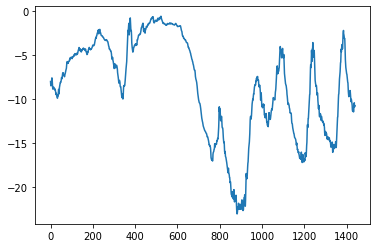

In [4]:
plt.plot(range(1440),temp[:1440])
plt.show()

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if(max_index is None):
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while(1):
        if shuffle:
            rows = np.random.randint(min_index+lookback,max_index,size=batch_size)
        else:
            if i+ batch_size >= max_index:
                i = min_index+ lookback
            rows = np.arange(i,min(i+batch_size,max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                            lookback//step,
                           data.shape[-1]))
        #zers((a,b,c));a,b,c表示由外到内的元素个数
        targets = np.zeros((len(rows),))
        for j,row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j]+delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,delay=delay,lookback=lookback,min_index=0,max_index=200000,step=step,batch_size=batch_size)
val_gen = generator(float_data,delay=delay,lookback=lookback,min_index=200001,max_index=300000,step=step,batch_size=batch_size)
test_gen = generator(float_data,delay=delay,lookback=lookback,min_index=300001,max_index=None,step=step,batch_size=batch_size)

val_steps = (300000-200001-lookback) // batch_size
test_steps = (len(float_data)-300001-lookback) // batch_size

In [8]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples,targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


In [9]:
celsius_mae = 0.29 * std[1]

In [10]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step,float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),
             loss='mae',)
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 17s 33ms/step - loss: 2.4905 - val_loss: 4.9314
Epoch 2/20
500/500 [==============================] - 17s 33ms/step - loss: 2.3911 - val_loss: 1.8303
Epoch 3/20
500/500 [==============================] - 17s 33ms/step - loss: 2.0562 - val_loss: 1.6145
Epoch 4/20
500/500 [==============================] - 17s 33ms/step - loss: 1.3160 - val_loss: 1.2261
Epoch 5/20
500/500 [==============================] - 17s 33ms/step - loss: 0.9854 - val_loss: 1.3713
Epoch 6/20
500/500 [==============================] - 17s 33ms/step - loss: 0.6091 - val_loss: 0.5368
Epoch 7/20
500/500 [==============================] - 16s 33ms/step - loss: 0.4705 - val_loss: 0.9197
Epoch 8/20
500/500 [==============================] - 16s 33ms/step - loss: 0.4018 - val_loss: 0.9252
Epoch 9/20
500/500 [==============================] - 16s 33ms/step - loss: 0.3409 - val_loss: 0.8285
Epoch 

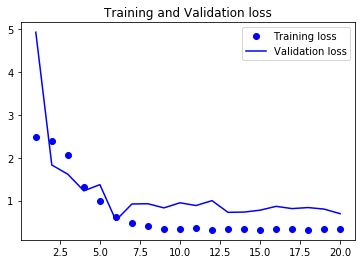

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

Epoch 1/20
500/500 [==============================] - 18s 37ms/step - loss: 0.3247 - val_loss: 0.5594
Epoch 2/20
500/500 [==============================] - 17s 35ms/step - loss: 0.3049 - val_loss: 0.4374
Epoch 3/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2931 - val_loss: 0.3293
Epoch 4/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2917 - val_loss: 0.3606
Epoch 5/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2964 - val_loss: 0.3592
Epoch 6/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2859 - val_loss: 0.3082
Epoch 7/20
500/500 [==============================] - 19s 37ms/step - loss: 0.2831 - val_loss: 0.3327
Epoch 8/20
500/500 [==============================] - 18s 37ms/step - loss: 0.3017 - val_loss: 0.2886
Epoch 9/20
500/500 [==============================] - 18s 37ms/step - loss: 0.2761 - val_loss: 0.4056
Epoch 10/20
500/500 [==============================] - 19s 37ms/step - loss: 0.281

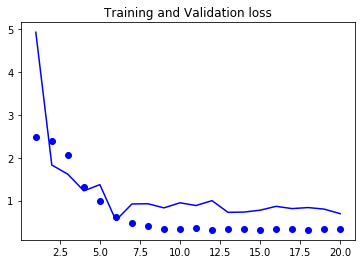

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model =  Sequential()
model.add(layers.GRU(32,input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),loss='mae')
histroy = model.fit(train_gen,steps_per_epoch=500,epochs=20,validation_data=val_gen,validation_steps=val_steps)

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')

plt.show()

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,dropout=0.2,recurrent_dropout=0.2,input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),
             loss='mae')
history = model.fit(train_gen,steps_per_epoch=500,
                   epochs=40,
                   validation_data=val_gen,
                   validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')

plt.show()

Epoch 1/40
500/500 [==============================] - 710s 1s/step - loss: 0.3257 - val_loss: 0.3597
Epoch 2/40
500/500 [==============================] - 693s 1s/step - loss: 0.3151 - val_loss: 0.3141
Epoch 3/40
500/500 [==============================] - 692s 1s/step - loss: 0.3125 - val_loss: 0.5437
Epoch 4/40
500/500 [==============================] - 695s 1s/step - loss: 0.2998 - val_loss: 0.5101
Epoch 5/40
500/500 [==============================] - 700s 1s/step - loss: 0.2983 - val_loss: 0.3116
Epoch 6/40
500/500 [==============================] - 724s 1s/step - loss: 0.3148 - val_loss: 0.3955
Epoch 7/40
500/500 [==============================] - 714s 1s/step - loss: 0.2993 - val_loss: 0.4205
Epoch 8/40
500/500 [==============================] - 728s 1s/step - loss: 0.2904 - val_loss: 0.3453
Epoch 9/40
500/500 [==============================] - 729s 1s/step - loss: 0.3034 - val_loss: 0.4311
Epoch 10/40
490/500 [============================>.] - ETA: 13s - loss: 0.3136

KeyboardInterrupt: 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True,input_shape=(None,float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(),
             loss='mae')
history = model.fit(train_gen,steps_per_epoch=500,
                   epochs=40,
                   validation_data=val_gen,
                   validation_steps=val_steps)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and Validation loss')

plt.show()